# Basic feature interrelation analysis using the 'fip3' library

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import csv

from fip import profiles

In [2]:
DATASET_NAME = 'ChEMBL28'
DATASET_LINK = '../../scratch/data/chembl_28/chembl_compounds_activities_features.csv'
OUTPUT_FIGURE_PATH = '../../scratch/data/chembl_28/pix'

FEATURES_NAME = 'ECFP1-like substructures'
COOCCURRENCE_MX_LINK = '../../scratch/data/chembl_28/ec_fragments_r1_coomx.csv'
COOCCURRENCE_MX_VECTOR_COUNT = 2066376

HYBRID_FEATURES_NAME = FEATURES_NAME + " and ChEMBL activities"
HYBRID_COOCCURRENCE_MX_LINK = '../../scratch/data/chembl_28/ec_fragments_r1_activities_coomx.csv'
HYBRID_COOCCURRENCE_MX_VECTOR_COUNT = COOCCURRENCE_MX_VECTOR_COUNT

REFERENCE_DATASET_NAME = 'ZINC_DM'
REFERENCE_DATASET_LINK = '../../scratch/data/zinc_dark_matter/zinc_dm_in_stock_features.csv'
REFERENCE_COOCCURRENCE_MX_LINK = '../../scratch/data/zinc_dark_matter/zinc_dm_in_stock_ec_fragments_r1_coomx.csv'
REFERENCE_COOCCURRENCE_MX_VECTOR_COUNT = 5063486

MINIMAL_COOCCURRENCE_CUTOFF = 10  # How many co-occurrences are needed to start tracking the relation

## Loading interrelation profiles
From interrelation files already preprocessed by scripts in fip3/scripts

In [3]:
p = profiles.CooccurrenceProfile.from_dataframe(
    pd.read_csv(COOCCURRENCE_MX_LINK), min_cutoff_value=MINIMAL_COOCCURRENCE_CUTOFF)
p

In [4]:
p.df

value
feature1 feature2            
C=O      C=O          1424230
         Cc(c)c        624876
         c-n(c)n        37580
         c=O           120205
         cC            273990
...                       ...
c=C(N)O  ccn               11
C=NN     C=c               11
C=c      CNN               11
c-c(n)s  nc(-n)[nH]        10
CCI      NS(=O)(=O)O       13

[112129 rows x 1 columns]

## General characterization of a co-occurrence profile

In [5]:
print(f"There are {len(p.distinct_features())} distinct {FEATURES_NAME} within {DATASET_NAME}.")

There are 1640 distinct ECFP1-like substructures within ChEMBL28.


In [6]:
self_relations_values = p.select_self_relations()['value']
self_relations_values

feature1    feature2  
C=O         C=O           1424230
Cc(c)c      Cc(c)c         717878
c-n(c)n     c-n(c)n         55340
c=O         c=O            222434
cC          cC             408262
                           ...   
cC[Te]      cC[Te]             10
BO[Si]      BO[Si]             22
NC(=O)[S-]  NC(=O)[S-]         15
[N+][N-]S   [N+][N-]S          20
BC(c)=C     BC(c)=C            14
Name: value, Length: 1640, dtype: int64

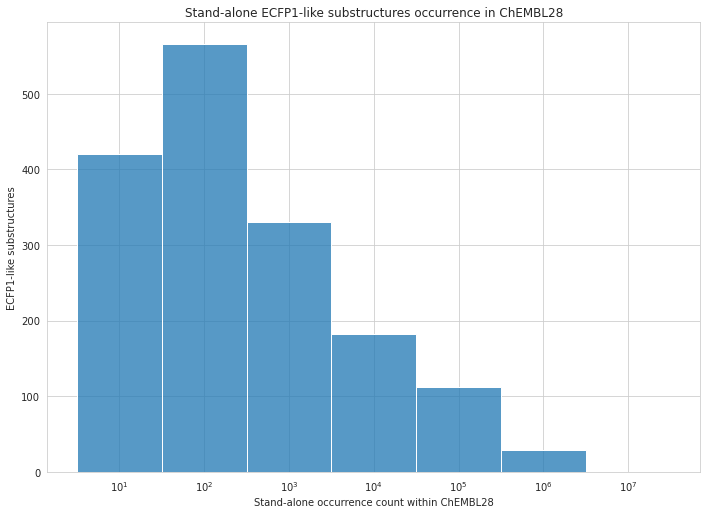

In [7]:
title = f"Stand-alone {FEATURES_NAME} occurrence in {DATASET_NAME}"
a4_dims = (11.7, 8.27)
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=a4_dims)
sns.histplot(self_relations_values, log_scale=True, discrete=True)
ax.set(title=title, xlabel=f"Stand-alone occurrence count within {DATASET_NAME}", ylabel=f"{FEATURES_NAME}")
plt.savefig(f"{OUTPUT_FIGURE_PATH}/{title}.svg", format="svg")
#plt.close()

In [8]:
cooccurrence_values = p.select_raw_interrelations()['value']
cooccurrence_values

feature1  feature2   
C=O       Cc(c)c         624876
          c-n(c)n         37580
          c=O            120205
          cC             273990
          cC(c)=O         30748
                          ...  
c=C(N)O   ccn                11
C=NN      C=c                11
C=c       CNN                11
c-c(n)s   nc(-n)[nH]         10
CCI       NS(=O)(=O)O        13
Name: value, Length: 110489, dtype: int64

In [9]:
print(f"There is in total {self_relations_values.sum()} feature stand-alone occurrences and \
{cooccurrence_values.sum()} feature co-occurrences for {FEATURES_NAME} within {DATASET_NAME}")

There is in total 33715089 feature stand-alone occurrences and 279126440 feature co-occurrences for ECFP1-like substructures within ChEMBL28


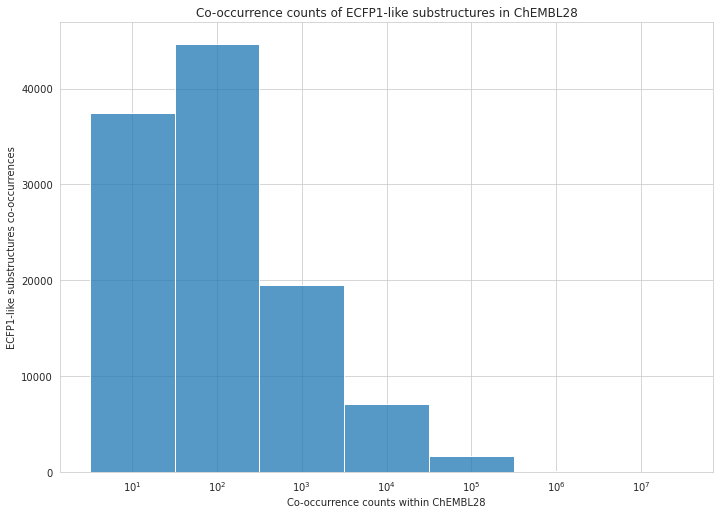

In [10]:
title = f"Co-occurrence counts of {FEATURES_NAME} in {DATASET_NAME}"
a4_dims = (11.7, 8.27)
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=a4_dims)
sns.histplot(cooccurrence_values, log_scale=True, discrete=True)
ax.set(title=title, xlabel=f"Co-occurrence counts within {DATASET_NAME}",
       ylabel=f"{FEATURES_NAME} co-occurrences")
plt.savefig(f"{OUTPUT_FIGURE_PATH}/{title}.svg", format="svg")
#plt.close()

In [11]:
print(f"The maximum theoretical number of different feature interrelations of the observed {FEATURES_NAME} \
within {DATASET_NAME} would be {int(p.num_max_interrelations())}, whereas the number of actual observed \
interrelations is only {p.num_raw_interrelations()}. Therefore, the interrelation matrix population ratio is \
approx. {p.num_raw_interrelations() / p.num_max_interrelations():.4f}.")

The maximum theoretical number of different feature interrelations of the observed ECFP1-like substructures within ChEMBL28 would be 1343980, whereas the number of actual observed interrelations is only 110489. Therefore, the interrelation matrix population ratio is approx. 0.0822.


In [12]:
print(f"The mean co-occurrence value for {FEATURES_NAME} within {DATASET_NAME} \
is {p.mean_raw_interrelation_value():.2f}, \
with the standard deviation of {p.standard_raw_interrelation_deviation():.2f}. \
The mean stand-alone value is {p.mean_self_relation_value():.2f}, \
with the standard deviation of {p.standard_self_relation_deviation():.2f}.")

The mean co-occurrence value for ECFP1-like substructures within ChEMBL28 is 2526.28, with the standard deviation of 19737.91. The mean stand-alone value is 20557.98, with the standard deviation of 104840.67.


## General characterization of pointwise mutual information profile

In [13]:
p = profiles.CooccurrenceProbabilityProfile.from_cooccurrence_profile(
    p, vector_count=COOCCURRENCE_MX_VECTOR_COUNT)
p

In [14]:
p.select_self_relations()['value']

feature1    feature2  
C=O         C=O           0.689240
Cc(c)c      Cc(c)c        0.347409
c-n(c)n     c-n(c)n       0.026781
c=O         c=O           0.107644
cC          cC            0.197574
                            ...   
cC[Te]      cC[Te]        0.000005
BO[Si]      BO[Si]        0.000011
NC(=O)[S-]  NC(=O)[S-]    0.000007
[N+][N-]S   [N+][N-]S     0.000010
BC(c)=C     BC(c)=C       0.000007
Name: value, Length: 1640, dtype: float64

In [15]:
p.select_self_relations()['value'].min()

4.83939031425065e-06

In [16]:
p.select_raw_interrelations()['value'].min()

4.83939031425065e-06

In [17]:
p = profiles.PointwiseMutualInformationProfile.from_cooccurrence_probability_profile(p)

p

In [18]:
p.df

value
feature1 feature2             
C=O      C=O          0.000000
         Cc(c)c       0.336752
         c-n(c)n     -0.021437
         c=O         -0.350960
         cC          -0.038451
...                        ...
c=C(N)O  ccn          1.220514
C=NN     C=c          4.198753
C=c      CNN          4.381283
c-c(n)s  nc(-n)[nH]  -0.033334
CCI      NS(=O)(=O)O  3.943011

[112129 rows x 1 columns]

In [19]:
pmi_values = p.select_raw_interrelations()['value']
pmi_values

feature1  feature2   
C=O       Cc(c)c         0.336752
          c-n(c)n       -0.021437
          c=O           -0.350960
          cC            -0.038451
          cC(c)=O        0.536921
                           ...   
c=C(N)O   ccn            1.220514
C=NN      C=c            4.198753
C=c       CNN            4.381283
c-c(n)s   nc(-n)[nH]    -0.033334
CCI       NS(=O)(=O)O    3.943011
Name: value, Length: 110489, dtype: float64

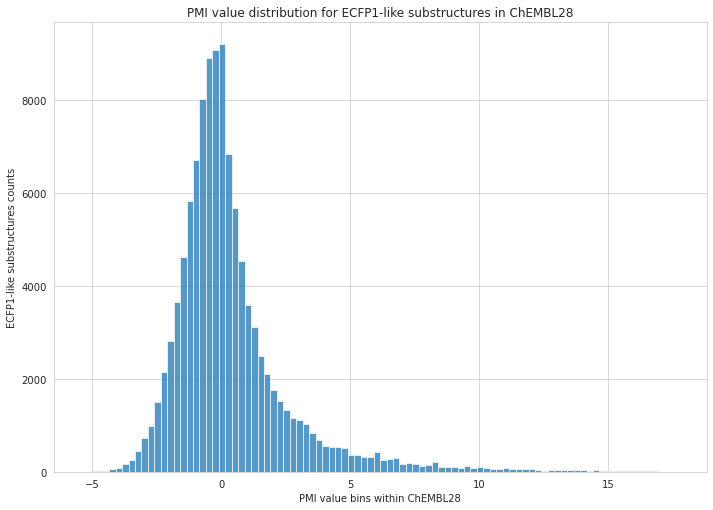

In [20]:
title = f"PMI value distribution for {FEATURES_NAME} in {DATASET_NAME}"
a4_dims = (11.7, 8.27)
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=a4_dims)
sns.histplot(pmi_values, binwidth=0.25)
ax.set(title=title, xlabel=f"PMI value bins within {DATASET_NAME}", ylabel=f"{FEATURES_NAME} counts")
plt.savefig(f"{OUTPUT_FIGURE_PATH}/{title}.svg", format="svg")
#plt.close()

In [21]:
print(f"The mean PMI value for {FEATURES_NAME} within {DATASET_NAME} \
is {p.mean_raw_interrelation_value():.2f}, \
with the standard deviation of {p.standard_raw_interrelation_deviation():.2f}. \
The mean stand-alone value is {p.mean_self_relation_value():.2f}, \
with the standard deviation of {p.standard_self_relation_deviation():.2f}.")

The mean PMI value for ECFP1-like substructures within ChEMBL28 is 0.36, with the standard deviation of 2.32. The mean stand-alone value is 0.00, with the standard deviation of 0.00.


In [22]:
major_pmi_values = p.select_major_interrelations(2)['value']
major_pmi_values

feature1       feature2  
cc([nH])=O     nc([nH])=O     5.251617
cC[n+]         c[n+](c)C      6.626132
               cc(c)[n+]      5.581563
               cc[n+]         6.497581
c[n+](c)C      cc(c)[n+]      6.061171
                               ...    
CC(=N)O        NBr            9.758454
CC(C)(C)Br     NBr           11.867710
NBr            cC(c)C         5.882763
[nH]c([nH])=O  cn(c)[nH]      5.869877
C=c            c=C(N)O       16.323320
Name: value, Length: 5178, dtype: float64

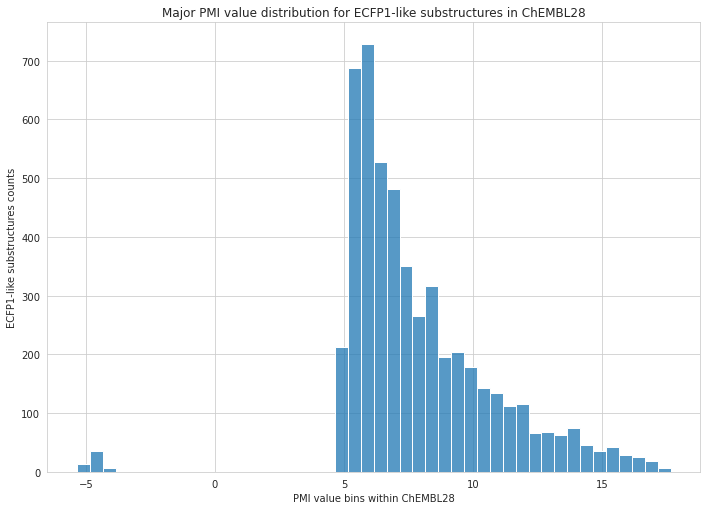

In [23]:
title = f"Major PMI value distribution for {FEATURES_NAME} in {DATASET_NAME}"
a4_dims = (11.7, 8.27)
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=a4_dims)
sns.histplot(major_pmi_values, binwidth=0.5)
ax.set(title=title, xlabel=f"PMI value bins within {DATASET_NAME}", ylabel=f"{FEATURES_NAME} counts")
plt.savefig(f"{OUTPUT_FIGURE_PATH}/{title}.svg", format="svg")
#plt.close()

In [24]:
p.mean_raw_interrelation_value()

0.3625016352839537

## Graph visualization of PMI profile

In [25]:
graph = nx.Graph()
major_pmi_values = p.select_major_interrelations(2)

for feature_pair, value in major_pmi_values[major_pmi_values['value'] > 0].iterrows():
    graph.add_edge(feature_pair[0], feature_pair[1], weight=float(value))
graph

In [26]:
title = f"Kamada-Kawai graph visualization of major PMI interrelations for {FEATURES_NAME} in {DATASET_NAME}"
dims = (40, 40)
fig, ax = plt.subplots(figsize=dims)
nx.draw_kamada_kawai(graph, ax=ax, alpha=0.5, node_size=30, label=title)
plt.savefig(f"{OUTPUT_FIGURE_PATH}/{title}.svg", format="svg")
plt.close()

In [27]:
title = f"Circular graph visualization of major PMI interrelations for {FEATURES_NAME} in {DATASET_NAME}"
dims = (40, 40)
fig, ax = plt.subplots(figsize=dims)
nx.draw_circular(graph, ax=ax, alpha=0.2, node_size=30)
plt.savefig(f"{OUTPUT_FIGURE_PATH}/{title}.svg", format="svg")
plt.close()

In [28]:
title = f"A generic graph visualization of major PMI interrelations for {FEATURES_NAME} in {DATASET_NAME}"
dims = (40, 40)
fig, ax = plt.subplots(figsize=dims)
nx.draw_networkx(graph, ax=ax, alpha=0.1, node_size=30)
plt.savefig(f"{OUTPUT_FIGURE_PATH}/{title}.svg", format="svg")
plt.close()

## General characterization of a hybrid co-occurrence profile

In [29]:
q = profiles.CooccurrenceProfile.from_dataframe(
    pd.read_csv(HYBRID_COOCCURRENCE_MX_LINK), min_cutoff_value=MINIMAL_COOCCURRENCE_CUTOFF)
q

In [30]:
q.df

value
feature1                                       feature2            
C=O                                            C=O          1417382
                                               Cc(c)c        621764
                                               c-n(c)n        37498
                                               c=O           119809
                                               cC            272969
...                                                             ...
CS(N)(=O)=O                                    PC-14             10
ATP-dependent Clp protease proteolytic subunit CO                10
c-c(n)s                                        nc(-n)[nH]        10
NS(=O)(=O)O                                    cc(n)Cl           25
CCI                                            NS(=O)(=O)O       13

[448279 rows x 1 columns]

In [31]:
target_set = set()
with open(DATASET_LINK, 'r') as dataset:
    reader = csv.DictReader(dataset)
    for row in reader:
        activities = row['chembl_activities'].split(" | ")
        for activity in activities:
            activity = activity.strip()
            if activity:
                target_set.add(activity)
len(target_set)

5507

In [32]:
interrelation_type = ['feature-feature', 'feature-activity', 'activity-activity']
q.df['type'] = [interrelation_type[sum((x in target_set, y in target_set))]
                                   for x, y in zip(q.df.index.get_level_values(0),
                                                   q.df.index.get_level_values(1))]
q.df

value  \
feature1                                       feature2               
C=O                                            C=O          1417382   
                                               Cc(c)c        621764   
                                               c-n(c)n        37498   
                                               c=O           119809   
                                               cC            272969   
...                                                             ...   
CS(N)(=O)=O                                    PC-14             10   
ATP-dependent Clp protease proteolytic subunit CO                10   
c-c(n)s                                        nc(-n)[nH]        10   
NS(=O)(=O)O                                    cc(n)Cl           25   
CCI                                            NS(=O)(=O)O       13   

                                                                        type  
feature1                                       feature2                       
C=O                                            C=O           feature-feature  
                                               Cc(c)c        feature-feature  
                                               c-n(c)n       feature-feature  
                                               c=O           feature-feature  
                                               cC            feature-feature  
...                                                                      ...  
CS(N)(=O)=O                                    PC-14        feature-activity  
ATP-dependent Clp protease proteolytic subunit CO           feature-activity  
c-c(n)s                                        nc(-n)[nH]    feature-feature  
NS(=O)(=O)O                                    cc(n)Cl       feature-feature  
CCI                                            NS(=O)(=O)O   feature-feature  

[448279 rows x 2 columns]

In [33]:
q.select_self_relations().loc[q.df.type=='activity-activity']

,,value,type
feature1,feature2,,
Small conductance calcium-activated potassium channel,Small conductance calcium-activated potassium channel,74,activity-activity
Small conductance calcium-activated potassium channel protein 2,Small conductance calcium-activated potassium channel protein 2,22,activity-activity
Aldehyde dehydrogenase 1A1,Aldehyde dehydrogenase 1A1,2113,activity-activity
Anandamide amidohydrolase,Anandamide amidohydrolase,2103,activity-activity
Bloom syndrome protein,Bloom syndrome protein,328,activity-activity
...,...,...,...
Histone-lysine N-methyltransferase SUV39H2,Histone-lysine N-methyltransferase SUV39H2,460,activity-activity
CCD-18Co,CCD-18Co,26,activity-activity
S-adenosylmethionine synthase isoform type-2,S-adenosylmethionine synthase isoform type-2,56,activity-activity


In [34]:
print(f"There are {len(q.distinct_features())} distinct {HYBRID_FEATURES_NAME} within {DATASET_NAME}, \
of which there are {len(q.select_self_relations().loc[q.df.type=='activity-activity'])} ChEMBL activities.")

There are 5195 distinct ECFP1-like substructures and ChEMBL activities within ChEMBL28, of which there are 3292 ChEMBL activities.


In [35]:
hybrid_self_relations_values = q.select_self_relations()['value']
hybrid_self_relations_values

feature1                                      feature2                                    
C=O                                           C=O                                             1417382
Cc(c)c                                        Cc(c)c                                           714416
c-n(c)n                                       c-n(c)n                                           55160
c=O                                           c=O                                              221633
cC                                            cC                                               406260
                                                                                               ...   
Histone-lysine N-methyltransferase SUV39H2    Histone-lysine N-methyltransferase SUV39H2          460
CCD-18Co                                      CCD-18Co                                             26
S-adenosylmethionine synthase isoform type-2  S-adenosylmethionine synthase isoform type-2   

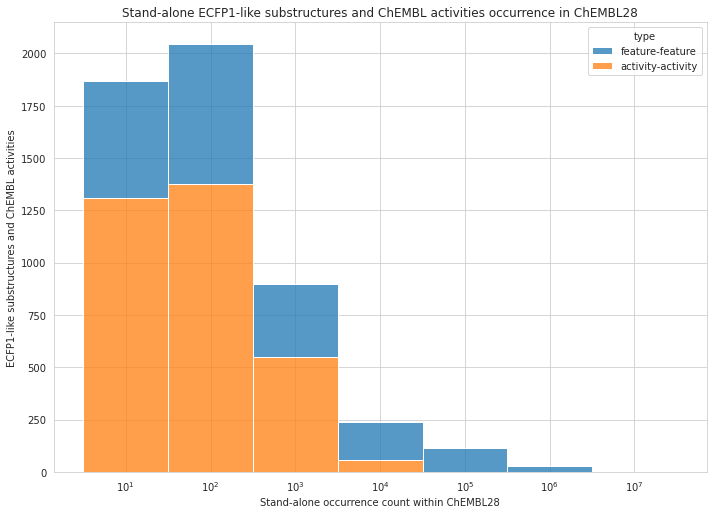

In [36]:
title = f"Stand-alone {HYBRID_FEATURES_NAME} occurrence in {DATASET_NAME}"
a4_dims = (11.7, 8.27)
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=a4_dims)
sns.histplot(q.select_self_relations(), log_scale=True, discrete=True, 
             x="value", hue="type", multiple="stack")
ax.set(title=title, xlabel=f"Stand-alone occurrence count within {DATASET_NAME}",
       ylabel=f"{HYBRID_FEATURES_NAME}")
plt.savefig(f"{OUTPUT_FIGURE_PATH}/{title}.svg", format="svg")
#plt.close()

In [37]:
hybrid_cooccurrence_values = q.select_raw_interrelations()['value']
hybrid_cooccurrence_values

feature1                                        feature2   
C=O                                             Cc(c)c         621764
                                                c-n(c)n         37498
                                                c=O            119809
                                                cC             272969
                                                cC(c)=O         30629
                                                                ...  
CS(N)(=O)=O                                     PC-14              10
ATP-dependent Clp protease proteolytic subunit  CO                 10
c-c(n)s                                         nc(-n)[nH]         10
NS(=O)(=O)O                                     cc(n)Cl            25
CCI                                             NS(=O)(=O)O        13
Name: value, Length: 443084, dtype: int64

In [38]:
print(f"There is in total {self_relations_values.sum()} feature stand-alone occurrences and \
{hybrid_cooccurrence_values.sum()} feature co-occurrences for {HYBRID_FEATURES_NAME} within {DATASET_NAME}")

There is in total 33715089 feature stand-alone occurrences and 299308795 feature co-occurrences for ECFP1-like substructures and ChEMBL activities within ChEMBL28


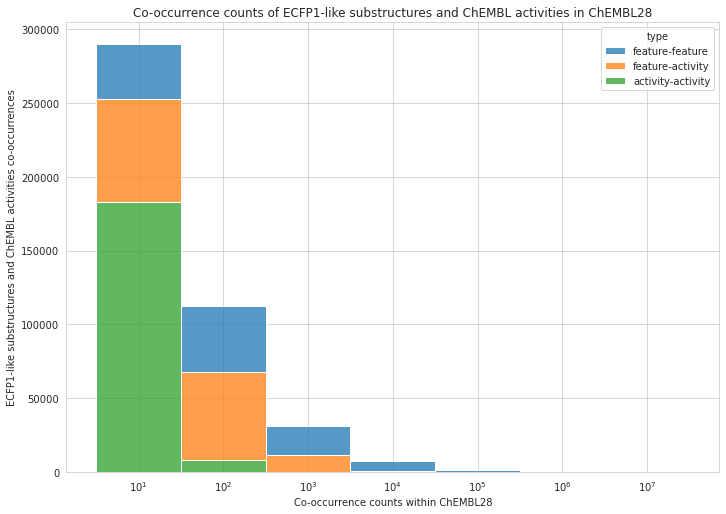

In [39]:
title = f"Co-occurrence counts of {HYBRID_FEATURES_NAME} in {DATASET_NAME}"
a4_dims = (11.7, 8.27)
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=a4_dims)
sns.histplot(q.select_raw_interrelations(), log_scale=True, discrete=True,
             x="value", hue="type", multiple="stack")
ax.set(title=title, xlabel=f"Co-occurrence counts within {DATASET_NAME}",
       ylabel=f"{HYBRID_FEATURES_NAME} co-occurrences")
plt.savefig(f"{OUTPUT_FIGURE_PATH}/{title}.svg", format="svg")
#plt.close()

In [40]:
q = profiles.CooccurrenceProbabilityProfile.from_cooccurrence_profile(
    q, vector_count=HYBRID_COOCCURRENCE_MX_VECTOR_COUNT)
q = profiles.PointwiseMutualInformationProfile.from_cooccurrence_probability_profile(q)

In [41]:
q.df

value      type
feature1                                       feature2                       
C=O                                            C=O          0.000000          
                                               Cc(c)c       0.343477  0.343477
                                               c-n(c)n     -0.012935 -0.012935
                                               c=O         -0.343562 -0.343562
                                               cC          -0.029792 -0.029792
...                                                              ...       ...
CS(N)(=O)=O                                    PC-14        2.974874  2.974874
ATP-dependent Clp protease proteolytic subunit CO          -1.030133 -1.030133
c-c(n)s                                        nc(-n)[nH]  -0.026784 -0.026784
NS(=O)(=O)O                                    cc(n)Cl      0.191176  0.191176
CCI                                            NS(=O)(=O)O  3.984286  3.984286

[448279 rows x 2 columns]

In [42]:
# Fix the type write-through
q.df['type'] = [interrelation_type[sum((x in target_set, y in target_set))]
                                   for x, y in zip(q.df.index.get_level_values(0),
                                                   q.df.index.get_level_values(1))]
q.df

value  \
feature1                                       feature2                
C=O                                            C=O          0.000000   
                                               Cc(c)c       0.343477   
                                               c-n(c)n     -0.012935   
                                               c=O         -0.343562   
                                               cC          -0.029792   
...                                                              ...   
CS(N)(=O)=O                                    PC-14        2.974874   
ATP-dependent Clp protease proteolytic subunit CO          -1.030133   
c-c(n)s                                        nc(-n)[nH]  -0.026784   
NS(=O)(=O)O                                    cc(n)Cl      0.191176   
CCI                                            NS(=O)(=O)O  3.984286   

                                                                        type  
feature1                                       feature2                       
C=O                                            C=O           feature-feature  
                                               Cc(c)c        feature-feature  
                                               c-n(c)n       feature-feature  
                                               c=O           feature-feature  
                                               cC            feature-feature  
...                                                                      ...  
CS(N)(=O)=O                                    PC-14        feature-activity  
ATP-dependent Clp protease proteolytic subunit CO           feature-activity  
c-c(n)s                                        nc(-n)[nH]    feature-feature  
NS(=O)(=O)O                                    cc(n)Cl       feature-feature  
CCI                                            NS(=O)(=O)O   feature-feature  

[448279 rows x 2 columns]

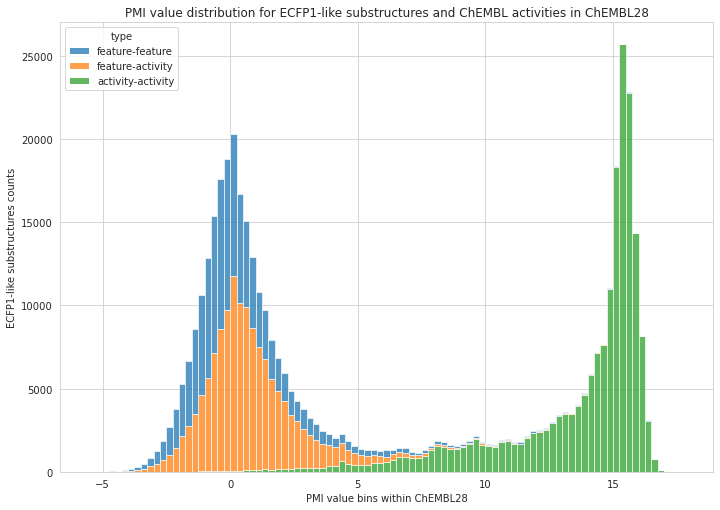

In [43]:
title = f"PMI value distribution for {HYBRID_FEATURES_NAME} in {DATASET_NAME}"
a4_dims = (11.7, 8.27)
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=a4_dims)
sns.histplot(q.select_raw_interrelations(), binwidth=0.25, x="value", hue="type", multiple="stack")
ax.set(title=title, xlabel=f"PMI value bins within {DATASET_NAME}", ylabel=f"{FEATURES_NAME} counts")
plt.savefig(f"{OUTPUT_FIGURE_PATH}/{title}.svg", format="svg")
#plt.close()

In [44]:
q.df.loc[q.df.type == 'activity-activity'].sort_values('value', ascending=False)[:100]

,,value,type
feature1,feature2,,
Carboxypeptidase A2,Carboxypeptidase A4,17.519240,activity-activity
D-423MG,D-566MG,17.381736,activity-activity
EPLC-272H,KNS-62,17.278232,activity-activity
C-4-II,NCI-H1734,17.256205,activity-activity
CCF-STTG1,U-698-M,17.171316,activity-activity
...,...,...,...
LC-1F,NCI-H748,16.808746,activity-activity
MC-CAR,SCLC-21H,16.808746,activity-activity
MDA-MB-415,RO82-W-1,16.808746,activity-activity
